In [1]:
import itertools
import os
import time

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pylab

import cirq
import openfermion
import openfermioncirq as ofc
from openfermioncirq.optimization import OptimizationParams, ScipyOptimizationAlgorithm
from openfermionpyscf import run_pyscf

/home/ana-tudor/quantum/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [ ]:
def generate_input_params():
    bounds = [1,1,1,1,2,1,2,1,2,1,2,1,2,1,2,1]
    name = "imfil/16_params_init.txt"
    
    results = []
        
    for i in range(30):
        result = [(np.random.rand(1)*i-i/2).tolist()[0] for i in bounds]
        print(result)
        results.append(np.array(result))
        
        
    with open(name, 'wb') as f:
#         fmt='%d %d %d %d %d %d %d %d %d %d %d %d %d %d %d %d'
        np.savetxt(f, results, fmt='%s')
        
generate_input_params()

In [3]:
# Functions for generating molecular Hamiltonians
# -----------------------------------------------

def h2_geometry(bond_length):
    return [
        ('H', (0.0, 0.0, 0.0)),
        ('H', (0.0, 0.0, bond_length))
    ]


def n2_geometry(bond_length):
    return [
        ('N', (0.0, 0.0, 0.0)),
        ('N', (0.0, 0.0, bond_length))
    ]


def h2o_geometry(bond_length):
    bond_angle = numpy.pi * 104.5 / 180  # 104.5 degrees
    a = bond_length * numpy.cos(bond_angle / 2.0)
    b = bond_length * numpy.sin(bond_angle / 2.0)
    return [
        ('H', (a, b, 0.0)),
        ('H', (a, -b, 0.0)),
        ('O', (0.0, 0.0, 0.0))
    ]


def generate_molecular_hamiltonian(geometry,
                                   n_active_electrons,
                                   n_active_orbitals,
                                   basis='cc-pvdz',
                                   multiplicity=1):

    # Run electronic structure calculations
    molecule = run_pyscf(
        openfermion.hamiltonians.MolecularData(
            geometry, 
            basis,
            multiplicity
        )
    )

    # Freeze core orbitals and truncate to active space
    n_core_orbitals = (molecule.n_electrons - n_active_electrons) // 2
    occupied_indices = list(range(n_core_orbitals))
    active_indices = list(range(n_core_orbitals,
                                n_core_orbitals + n_active_orbitals))
    
    return molecule.get_molecular_hamiltonian(occupied_indices, active_indices)

In [4]:
# Create or load a variational study
# ----------------------------------

# Set directory to save studies in
STUDIES_DIR = 'studies'


# Set Hamiltonian parameters
geometry_factory = h2_geometry
bond_length = 1.4
n_active_electrons = 2
n_active_orbitals = 2
hamiltonian_name = 'H2_cc-pvdz_singlet_1.4_2-2'


# Set ansatz parameters
ansatz_class = ofc.SwapNetworkTrotterAnsatz
iterations = 1
ansatz_kwargs = {'include_all_xxyy': True}


# Generate Hamiltonian
hamiltonian = generate_molecular_hamiltonian(
    geometry_factory(bond_length),
    n_active_electrons,
    n_active_orbitals
)


# Create or load study
study_name = '{}_{}_iterations{}'.format(
    hamiltonian_name, ansatz_class.__name__, iterations)

if os.path.isfile(os.path.join(STUDIES_DIR, '{}.study'.format(study_name))):
    # Load study
    study = ofc.VariationalStudy.load(
        study_name,
        datadir=STUDIES_DIR)
    print("LOADED a variational study with {} qubits and {} parameters.".format(
        len(study.ansatz.qubits), study.num_params))
else:
    # Create study
    # Generate ansatz and objective
    hamiltonian_ferm_op = openfermion.get_fermion_operator(hamiltonian)
    ansatz_hamiltonian = openfermion.get_diagonal_coulomb_hamiltonian(
        hamiltonian_ferm_op,
        ignore_incompatible_terms=True)
    ansatz = ansatz_class(
        ansatz_hamiltonian,
        iterations=iterations,
        **ansatz_kwargs)
    objective = ofc.HamiltonianObjective(hamiltonian)

    # Use preparation circuit for mean-field state
    preparation_circuit = cirq.Circuit.from_ops(
        ofc.prepare_gaussian_state(
            ansatz.qubits,
            openfermion.QuadraticHamiltonian(ansatz_hamiltonian.one_body),
            occupied_orbitals=range(n_active_electrons)))

    study = ofc.VariationalStudy(
        study_name,
        ansatz,
        objective,
        preparation_circuit=preparation_circuit,
        datadir=STUDIES_DIR)
    print("CREATED a variational study with {} qubits and {} parameters.".format(
        len(study.ansatz.qubits), study.num_params))
    
hamiltonian_sparse = openfermion.get_sparse_operator(study.objective.hamiltonian)
energy, _ = openfermion.get_ground_state(hamiltonian_sparse)

target = energy
print(target)

LOADED a variational study with 4 qubits and 16 parameters.
-1.0480523474475656


In [70]:
def optimal_value(df):
    return min(get_col(df,33))

def absolute_error(fvalue):
    global target
    return np.abs(fvalue - target)

    
def gen_plot(x,y):
    fig = pylab.figure(figsize=(6,3))
#     pylab.subplot(1,2,1)
    pylab.plot(x,y, 'ro')
    
def get_col(df, num):
    if num<17:
        name = "init" + str(num)
    elif num>16 and num<33:
        name = "fin" + str(num-16)
    elif num==33:
        name = "fvalues"
    elif num==34:
        name = "iters"
    return df[name]
    
def inner_iters():
    x = np.array([1,2,3])
    return np.tile(x,10).tolist()
    
def errors(df):
    return [absolute_error(y) for y in get_col(df,33)]


def relative_errors(df):
    minim = optimal_value(df)
    return [np.abs(minim-y) for y in get_col(df,33)]
    
    
def gen_error_plot(df):
#     pylab.subplot(1,2,1)
    gen_plot(inner_iters(),relative_errors(df))
    pylab.ylabel('Error')
    pylab.xlabel('External iteration')
    pylab.title('Error varying by external iterations')
    
#     pylab.subplot(1,2,2)
    gen_plot(get_col(df,34),relative_errors(df))
    pylab.ylabel('Error')
    pylab.xlabel('Calls to objective function')
    pylab.title('Error varying by general num of iterations')

    
def gen_fvalue_vs_iters(df):
    gen_plot(get_col(df,34),get_col(df,33))
    pylab.xlabel('Iteration')
    pylab.ylabel('Function values')
    pylab.title('Function values varying by number of iterations')
    
def gen_fvalue_vs_params(df, ncols):
    fig = pylab.figure(figsize=(18,3))
    for x in ncols:
        pylab.subplot(130+ncols.index(x)+1)
        pylab.plot(get_col(df,x),get_col(df,33), 'ro')
        pylab.xlabel('Parameter ' + str(x))
        pylab.ylabel('Function values')
        pylab.title('Function values versus param ' + str(x))
 
                
        
def n_high_correlation(df,num):
    n=num
    ret = []
    while n > 0:
        corr = [np.std(get_col(df,i)) \
                for i in range(17,len(df.columns)-2)\
                if i not in ret]
        ind = corr.index(min(corr))+17
        ret.append(ind)
              
        n -= 1
    return ret
    
                
def display_data(filename, nparams):
    df = pd.read_csv(filename)
    
    ncols = n_high_correlation(df, nparams)
    print(ncols)
    gen_fvalue_vs_params(df, ncols)
        
    gen_fvalue_vs_iters(df)
    
    gen_error_plot(df)
    

[17, 27, 26]


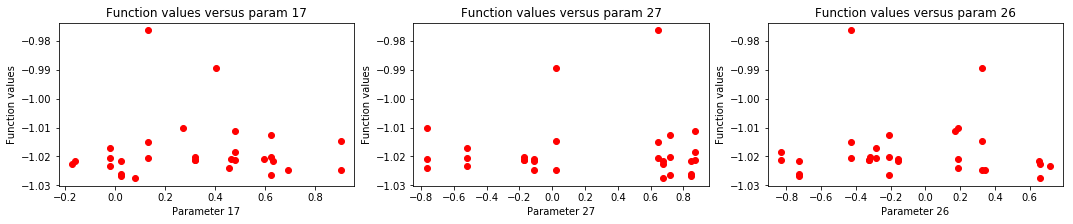

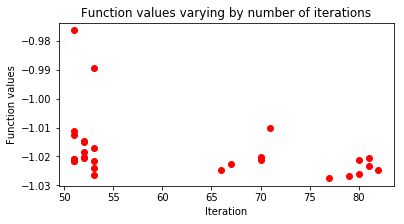

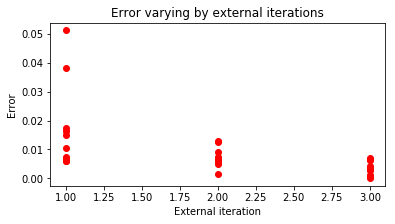

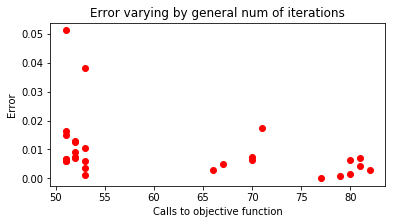

In [71]:
display_data('imfil/16_params_out.csv', 3)